In [1]:
import cv2
import datetime
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

In [2]:
# Let's make a dataset handling object to make our data more accessible as we complete our task.
class Dataset_Handler():
    def __init__(self, sequence, lidar=True):
        
        # Tells odometry function if handler contains lidar info
        self.lidar = lidar
        
        # Sets file paths and defines ground truth poses
        self.seq_dir = './dataset/sequences/{}/'.format(sequence)
        self.poses_dir = './dataset/poses/{}.txt'.format(sequence)
        poses = pd.read_csv(self.poses_dir, delimiter=' ', header=None)
        
        # Get name of files to iterate through
        self.left_image_files = sorted(os.listdir(self.seq_dir + 'image_0'))
        self.right_image_files = sorted(os.listdir(self.seq_dir + 'image_1'))
        self.velodyne_files = sorted(os.listdir(self.seq_dir + 'velodyne'))
        self.num_frames = len(self.left_image_files)
        self.lidar_path = self.seq_dir + 'velodyne/'
        
        # Get calibration settings from scene
        # P0 and P1 are grayscale. P2 and P3 are RGB
        calib = pd.read_csv(self.seq_dir + 'calib.txt', delimiter=' ', header=None, index_col=0)
        self.P0 = np.array(calib.loc['P0:']).reshape((3,4))
        self.P1 = np.array(calib.loc['P1:']).reshape((3,4))
        self.P2 = np.array(calib.loc['P2:']).reshape((3,4))
        self.P3 = np.array(calib.loc['P3:']).reshape((3,4))
        
        # Tranformation matrix for lidar
        self.Tr = np.array(calib.loc['Tr:']).reshape((3,4))
        
        # Get times and ground truth poses
        self.times = np.array(pd.read_csv(self.seq_dir + 'times.txt', 
                                          delimiter=' ', 
                                          header=None))
        self.gt = np.zeros((len(poses), 3, 4))
        for i in range(len(poses)):
            self.gt[i] = np.array(poses.iloc[i]).reshape((3, 4))
        
        # Get images and lidar loaded
        # Will use generators to provide data sequentially to save RAM
        self.reset_frames()
        # Store original frame to memory for testing functions
        self.first_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[0], 0)
        self.first_image_right = cv2.imread(self.seq_dir + 'image_1/' 
                                           + self.right_image_files[0], 0)
        self.second_image_left = cv2.imread(self.seq_dir + 'image_0/' 
                                           + self.left_image_files[1], 0)
        if self.lidar:
            self.first_pointcloud = np.fromfile(self.lidar_path + self.velodyne_files[0],
                                                dtype=np.float32, 
                                                count=-1).reshape((-1, 4))
        self.imheight = self.first_image_left.shape[0]
        self.imwidth = self.first_image_left.shape[1]
            
            
    def reset_frames(self):
        # Resets all generators to the first frame of the sequence
        self.images_left = (cv2.imread(self.seq_dir + 'image_0/' + name_left, 0)
                            for name_left in self.left_image_files)
        self.images_right = (cv2.imread(self.seq_dir + 'image_1/' + name_right, 0)
                            for name_right in self.right_image_files)
        if self.lidar:
            self.pointclouds = (np.fromfile(self.lidar_path + velodyne_file, 
                                            dtype=np.float32, 
                                            count=-1).reshape((-1, 4))
                                for velodyne_file in self.velodyne_files)
        pass

In [3]:
handler = Dataset_Handler('00')

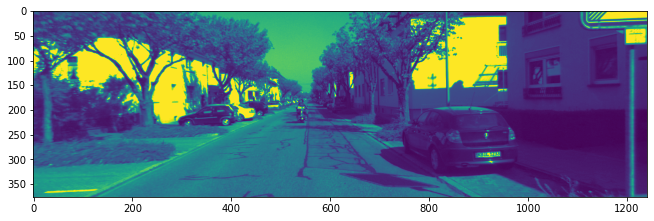

In [4]:
# This is the first left image
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_left);

In [5]:
print(f"The first left image has shape {handler.first_image_left.shape}")

The first left image has shape (376, 1241)


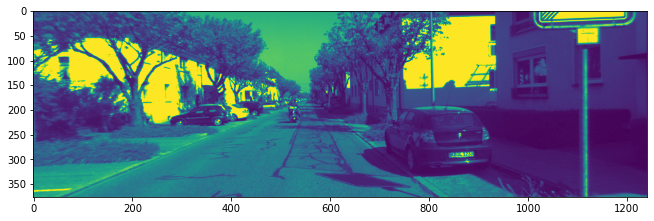

In [6]:
# This is the first right image
plt.figure(figsize=(11,7))
plt.imshow(handler.first_image_right);

In [7]:
print(f"Similarly, the first right image has shape {handler.first_image_right.shape}")

Similarly, the first right image has shape (376, 1241)


In [8]:
# Let's compute the disparities between the left and right images
# Notes: StereoBM is faster, but StereoSGBM produces better results
def compute_left_disparity_map(img_left, img_right, matcher='bm', rgb=False, verbose=False):
    '''
    Takes a left and right stereo pair of images and computes the disparity map for the left
    image. Pass rgb=True if the images are RGB.
    
    Arguments:
    img_left -- image from left camera
    img_right -- image from right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM matching
    rgb -- (bool) set to True if passing RGB images as input
    verbose -- (bool) set to True to report matching type and time to compute
    
    Returns:
    disp_left -- disparity map for the left camera image
    
    '''
    sad_window = 6
    num_disparities = sad_window * 16
    block_size = 11
    matcher_name = matcher
    
    if matcher_name == 'bm':
        matcher = cv2.StereoBM_create(numDisparities=num_disparities,
                                      blockSize=block_size)
        
    elif matcher_name == 'sgbm':
        matcher = cv2.StereoSGBM_create(numDisparities=num_disparities,
                                        minDisparity=0,
                                        blockSize=block_size,
                                        P1 = 8 * 1 * block_size ** 2,
                                        P2 = 32 * 1 * block_size ** 2,
                                        mode=cv2.STEREO_SGBM_MODE_SGBM_3WAY)
    
    if rgb:
        img_left = cv2.cvtColor(img_left, cv2.COLOR_BGR2GRAY)
        img_right = cv2.cvtColor(img_right, cv2.COLOR_BGR2GRAY)
        
    start = datetime.datetime.now()
    disp_left = matcher.compute(img_left, img_right).astype(np.float32)/16
    end = datetime.datetime.now()
    
    if verbose:
        print(f'Time to compute disparity map using Stereo{matcher_name.upper()}', end-start)
        
    return disp_left

Time to compute disparity map using StereoBM 0:00:00.010490


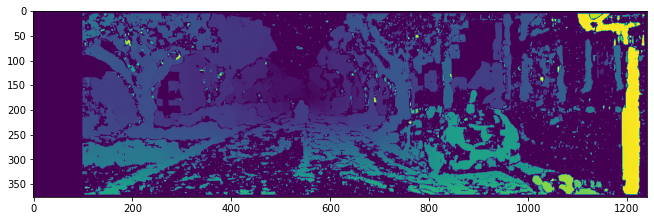

In [9]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='bm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

Time to compute disparity map using StereoSGBM 0:00:00.026232


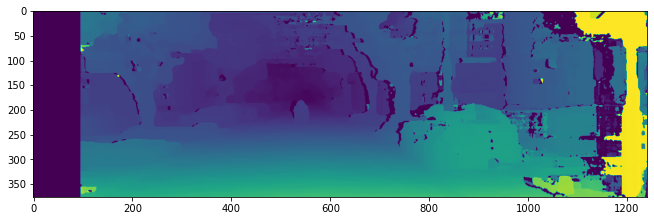

In [10]:
disp = compute_left_disparity_map(handler.first_image_left,
                                  handler.first_image_right,
                                  matcher='sgbm',
                                  verbose=True)
plt.figure(figsize=(11,7))
plt.imshow(disp);

In [ ]:
# We can see that StereoSGBM takes around 3x as long, but produces a much more contiguous
# disparity map, with less gaps in information

In [ ]:
# We can see that there is a gap of the left side of the image where the right camera did not have 
# matching information. This means that we should apply a mask when looking for features to match 
# from one frame to the next so that we can use features which fall in the area of the picture for 
# which we have depth information.

In [11]:
def decompose_projection_matrix(p):
    '''
    Shortcut to use cv2.decomposeProjectionMatrix(), which only returns k, r, t, and divides
    t by the scale, then returns it as a vector with shape (3,) (non-homogeneous)
    
    Arguments:
    p -- projection matrix to be decomposed
    
    Returns:
    k, r, t -- intrinsic matrix, rotation matrix, and 3D translation vector
    
    '''
    k, r, t, _, _, _, _ = cv2.decomposeProjectionMatrix(p)
    t = (t / t[3])[:3]
    
    return k, r, t

In [12]:
def calc_depth_map(disp_left, k_left, t_left, t_right, rectified=True):
    '''
    Calculate depth map using a disparity map, intrinsic camera matrix, and translation vectors
    from camera extrinsic matrices (to calculate baseline). Note that default behavior is for
    rectified projection matrix for right camera. If using a regular projection matrix, pass
    rectified=False to avoid issues.
    
    Arguments:
    disp_left -- disparity map of left camera
    k_left -- intrinsic matrix for left camera
    t_left -- translation vector for left camera
    t_right -- translation vector for right camera
    
    Optional Arguments:
    rectified -- (bool) set to False if t_right is not from rectified projection matrix
    
    Returns:
    depth_map -- calculated depth map for left camera
    
    '''
    if rectified:
        b = t_right[0] - t_left[0]
    else:
        b = t_left[0] - t_right[0]
        
    f = k_left[0][0]
    
    disp_left[disp_left == 0.0] = 0.1
    disp_left[disp_left == -1.0] = 0.1
    
    depth_map = np.ones(disp_left.shape)
    depth_map = f * b / disp_left
    
    return depth_map

In [13]:
k_left, r_left, t_left = decompose_projection_matrix(handler.P0)
k_right, r_right, t_right = decompose_projection_matrix(handler.P1)

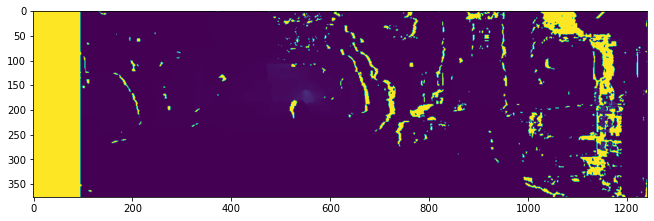

In [14]:
depth = calc_depth_map(disp, k_left, t_left, t_right)
plt.figure(figsize=(11,7))
plt.grid(False)
plt.imshow(depth);

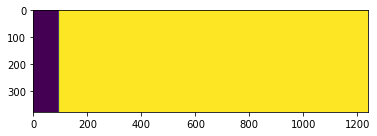

In [15]:
# We can constuct a mask using this information like so
mask = np.zeros(depth.shape, dtype=np.uint8)
ymax = depth.shape[0]
xmax = depth.shape[1]
cv2.rectangle(mask, (96, 0), (xmax, ymax), (255), thickness=-1)
plt.imshow(mask);

In [16]:
# Let's make an all-inclusive function to get the depth from an incoming set of stereo images
def stereo_2_depth(img_left, img_right, P0, P1, matcher='bm', rgb=False, verbose=False,
                   rectified=True):
    '''
    Takes stereo pair of images and returns a depth map for the left camera. If your projection
    matrices are not rectified, set rectified=False.
    
    Arguments:
    img_left -- image of left camera
    img_right -- image of right camera
    P0 -- Projection matrix for the left camera
    P1 -- Projection matrix for the right camera
    
    Optional Arguments:
    matcher -- (str) can be 'bm' for StereoBM or 'sgbm' for StereoSGBM
    rgb -- (bool) set to True if images passed are RGB. Default is False
    verbose -- (bool) set to True to report computation time and method
    rectified -- (bool) set to False if P1 not rectified to P0. Default is True
    
    Returns:
    depth -- depth map for left camera
    
    '''
    # Compute disparity map
    disp = compute_left_disparity_map(img_left,
                                      img_right,
                                      matcher=matcher,
                                      rgb=rgb,
                                      verbose=verbose)
    # Decompose projection matrices
    k_left, r_left, t_left = decompose_projection_matrix(P0)
    k_right, r_right, t_right = decompose_projection_matrix(P1)
    
    # Calculate depth map for left camera
    depth = calc_depth_map(disp, k_left, t_left, t_right)
    
    return depth

Time to compute disparity map using StereoSGBM 0:00:00.027275


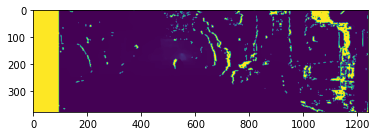

In [17]:
depth = stereo_2_depth(handler.first_image_left,
                       handler.first_image_right,
                       handler.P0,
                       handler.P1,
                       matcher='sgbm',
                       rgb=False,
                       verbose=True)
plt.grid(False)
plt.imshow(depth)

In [18]:
handler.first_pointcloud.shape

(124668, 4)

In [19]:
pcloud = handler.first_pointcloud
print('full pcloud shape', pcloud.shape)
trimmed_pcloud = pcloud[pcloud[:, 0] > 0]
print('trimmed pcloud shape', trimmed_pcloud.shape)

full pcloud shape (124668, 4)
trimmed pcloud shape (63141, 4)


In [20]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
#cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection /= projection[2]
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [21]:
hom_pcloud = np.hstack([trimmed_pcloud[:, :3], np.ones(trimmed_pcloud.shape[0]).reshape((-1,1))])
cam_xyz = handler.Tr.dot(trimmed_pcloud.T)
cam_xyz /= cam_xyz[2]
cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
projection = handler.P0.dot(cam_xyz)
projection[:, :5].T

array([[606.95511898, 152.8019536 ,   1.        ],
       [604.70040658, 152.93682998,   1.        ],
       [602.44536092, 152.95541569,   1.        ],
       [594.44678898, 153.74404704,   1.        ],
       [592.19822941, 153.75570653,   1.        ]])

In [22]:
pixel_coords = np.round(projection, 0).T.astype('int')
pixel_coords[:5]

array([[607, 153,   1],
       [605, 153,   1],
       [602, 153,   1],
       [594, 154,   1],
       [592, 154,   1]])

In [23]:
def pointcloud2image(pointcloud, imheight, imwidth, Tr, P0):
    
    pointcloud = pointcloud[pointcloud[:, 0] > 0]
    reflectance = pointcloud[:, 3]
    # Make pointcloud homogeneous (X, Y, Z, 1)
    pointcloud = np.hstack([pointcloud[:, :3], np.ones(pointcloud.shape[0]).reshape((-1,1))])
    
    # Transform points into 3D coordinate frame of camera
    cam_xyz = Tr.dot(pointcloud.T)
    # Clip off negative z values
    cam_xyz = cam_xyz[:, cam_xyz[2] > 0]
    
    depth = cam_xyz[2].copy()
    
    cam_xyz /= cam_xyz[2]    
    cam_xyz = np.vstack([cam_xyz, np.ones(cam_xyz.shape[1])])
    projection = P0.dot(cam_xyz)
    pixel_coordinates = np.round(projection.T, 0)[:, :2].astype('int')
    
    indices = np.where((pixel_coordinates[:, 0] < imwidth)
                       & (pixel_coordinates[:, 0] >= 0)
                       & (pixel_coordinates[:, 1] < imheight)
                       & (pixel_coordinates[:, 1] >= 0))
    
    pixel_coordinates = pixel_coordinates[indices]
    depth = depth[indices]
    reflectance = reflectance[indices]
    
    render = np.zeros((imheight, imwidth))
    for j, (u, v) in enumerate(pixel_coordinates):
        if u >= imwidth or u < 0:
            continue
        if v >= imheight or v < 0:
            continue
        render[v, u] = depth[j]
        
    return render

In [24]:
render = pointcloud2image(handler.first_pointcloud, 
                          handler.imheight,
                          handler.imwidth,
                          handler.Tr,
                          handler.P0
                         )

In [25]:
render.shape

(376, 1241)

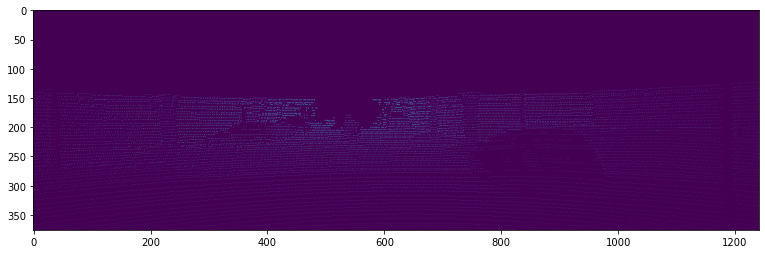

In [26]:
plt.figure(figsize=(13,5))
plt.imshow(render)

In [27]:
pcloud_frames = (pointcloud2image(next(handler.pointclouds),
                                  handler.imheight,
                                  handler.imwidth,
                                  handler.Tr,
                                  handler.P0)
                 for i in range(handler.num_frames))

#poses = (gt for gt in handler.gt)

In [28]:
%matplotlib tk

In [29]:
handler.reset_frames()
poses = (gt for gt in handler.gt)

In [30]:
xs = []
ys = []
zs = []
compute_times = []
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.view_init(elev=-20, azim=270)
ax.plot(handler.gt[:, 0, 3], handler.gt[:, 1, 3], handler.gt[:, 2, 3], c='k')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

stereo_l = handler.images_left
stereo_r = handler.images_right

for i in range(handler.num_frames // 50):
    img_l = next(stereo_l)
    img_r = next(stereo_r)
    start = datetime.datetime.now()
    disp = compute_left_disparity_map(img_l, img_r, matcher='sgbm')
    disp /= disp.max()
    #disp = 1 - disp
    disp = (disp*255).astype('uint8')
    #disp = cv2.applyColorMap(disp, cv2.COLORMAP_RAINBOW)
    pcloud = next(pcloud_frames)
    pcloud /= pcloud.max()
    pcloud = (pcloud*255).astype('uint8')
    
    
    gt = next(poses)
    xs.append(gt[0, 3])
    ys.append(gt[1, 3])
    zs.append(gt[2, 3])
    plt.plot(xs, ys, zs, c='chartreuse')
    plt.pause(0.000000000000000001)
    cv2.imshow('camera', img_l)
    cv2.imshow('disparity', disp)
    cv2.imshow('lidar', pcloud)
    cv2.waitKey(1)
    
    end = datetime.datetime.now()
    compute_times.append(end-start)
    
plt.close()
cv2.destroyAllWindows()

In [31]:
plt.close()

In [32]:
def extract_features(image, detector='sift', mask=None):
    """
    Find keypoints and descriptors for the image

    Arguments:
    image -- a grayscale image

    Returns:
    kp -- list of the extracted keypoints (features) in an image
    des -- list of the keypoint descriptors in an image
    """
    if detector == 'sift':
        det = cv2.SIFT_create()
    elif detector == 'orb':
        det = cv2.ORB_create()
    elif detector == 'surf':
        det = cv2.xfeatures2d.SURF_create()
        
    kp, des = det.detectAndCompute(image, mask)
    
    return kp, des

In [33]:
def match_features(des1, des2, matching='BF', detector='sift', sort=True, k=2):
    """
    Match features from two images

    Arguments:
    des1 -- list of the keypoint descriptors in the first image
    des2 -- list of the keypoint descriptors in the second image
    matching -- (str) can be 'BF' for Brute Force or 'FLANN'
    detector -- (str) can be 'sift or 'orb'. Default is 'sift'
    sort -- (bool) whether to sort matches by distance. Default is True
    k -- (int) number of neighbors to match to each feature.

    Returns:
    matches -- list of matched features from two images. Each match[i] is k or less matches for 
               the same query descriptor
    """
    if matching == 'BF':
        if detector == 'sift':
            matcher = cv2.BFMatcher_create(cv2.NORM_L2, crossCheck=False)
        elif detector == 'orb':
            matcher = cv2.BFMatcher_create(cv2.NORM_HAMMING2, crossCheck=False)
        matches = matcher.knnMatch(des1, des2, k=k)
    elif matching == 'FLANN':
        FLANN_INDEX_KDTREE = 1
        index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees=5)
        search_params = dict(checks=50)
        matcher = cv2.FlannBasedMatcher(index_params, search_params)
        matches = matcher.knnMatch(des1, des2, k=k)
    
    if sort:
        matches = sorted(matches, key = lambda x:x[0].distance)

    return matches

In [34]:
def filter_matches_distance(matches, dist_threshold):
    """
    Filter matched features from two images by distance between the best matches

    Arguments:
    match -- list of matched features from two images
    dist_threshold -- maximum allowed relative distance between the best matches, (0.0, 1.0) 

    Returns:
    filtered_match -- list of good matches, satisfying the distance threshold
    """
    filtered_match = []
    for m, n in matches:
        if m.distance <= dist_threshold*n.distance:
            filtered_match.append(m)

    return filtered_match

In [38]:
def visualize_matches(image1, kp1, image2, kp2, match):
    """
    Visualize corresponding matches in two images

    Arguments:
    image1 -- the first image in a matched image pair
    kp1 -- list of the keypoints in the first image
    image2 -- the second image in a matched image pair
    kp2 -- list of the keypoints in the second image
    match -- list of matched features from the pair of images

    Returns:
    image_matches -- an image showing the corresponding matches on both image1 and image2 or None if you don't use this function
    """
    image_matches = cv2.drawMatches(image1, kp1, image2, kp2, match, None, flags=2)
    plt.figure(figsize=(16, 6), dpi=100)
    plt.imshow(image_matches)

In [42]:
%matplotlib inline

Time to compute disparity map using StereoSGBM 0:00:00.030042
Number of matches before filtering: 3206
Number of matches after filtering: 446


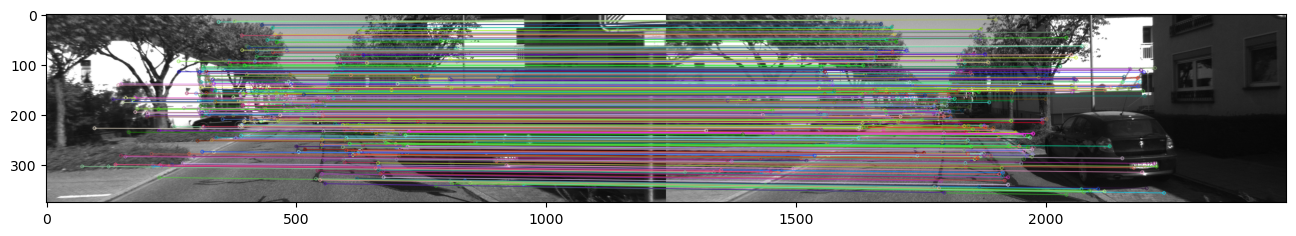

In [43]:
# Look at matched points using sgbm matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='sgbm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Time to compute disparity map using StereoBM 0:00:00.010273
Number of matches before filtering: 3206
Number of matches after filtering: 446


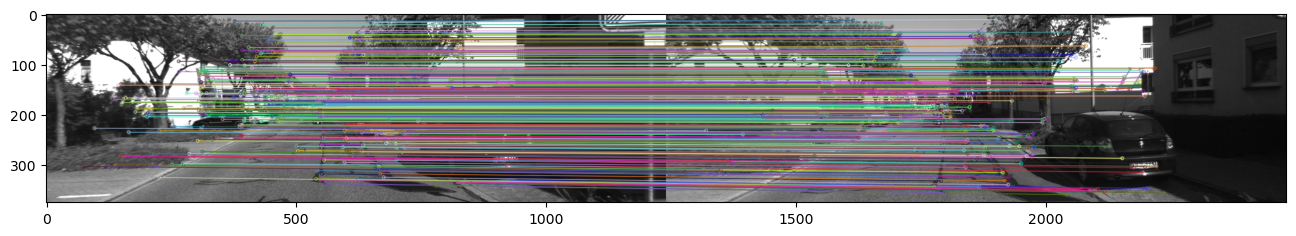

In [44]:
# Now to see the difference with 'bm' matcher
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
depth = stereo_2_depth(image_left, 
                       image_right, 
                       handler.P0, 
                       handler.P1,
                       matcher='bm',
                       verbose=True)
kp0, des0 = extract_features(image_left, 'sift')
kp1, des1 = extract_features(image_plus1, 'sift')
matches = match_features(des0, des1, matching='BF', detector='sift', sort=True)
print('Number of matches before filtering:', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering:', len(matches))
visualize_matches(image_left, kp0, image_plus1, kp1, matches)

Number of matches before filtering:  500
Number of matches after filtering:  19
Time to match and filter:  0:00:00.052754


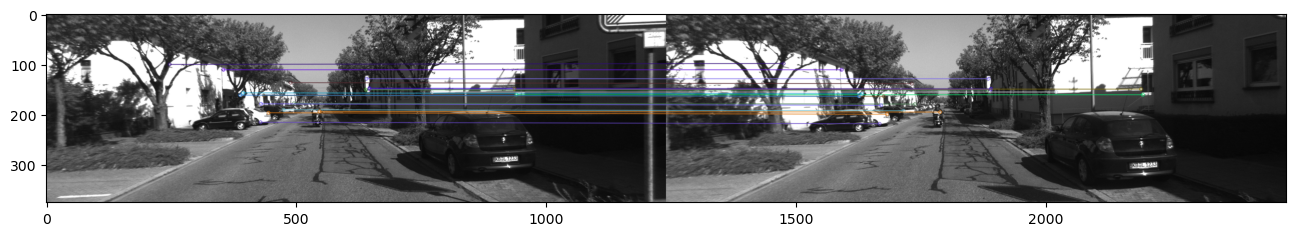

In [45]:
# Using the orb features/descriptors
image_left = handler.first_image_left
image_right = handler.first_image_right
image_plus1 = handler.second_image_left
start = datetime.datetime.now()
kp0, des0 = extract_features(image_left, 'orb', mask)
kp1, des1 = extract_features(image_plus1, 'orb', mask)
matches = match_features(des0, des1, matching='BF', detector='orb', sort=False)
print('Number of matches before filtering: ', len(matches))
matches = filter_matches_distance(matches, 0.3)
print('Number of matches after filtering: ', len(matches))
end = datetime.datetime.now()
print('Time to match and filter: ', end-start)
visualize_matches(image_left, kp0, image_plus1, kp1, matches)